In [1]:
import sys
sys.path.insert(0, "/home/jovyan/.local/share/virtualenvs/ptls-experiments-RyOSTDQK/lib/python3.8/site-packages")

In [2]:
from huggingface_hub import notebook_login
import gc
from glob import glob
import torch
from datasets import load_dataset
from transformers import logging
from tqdm import tqdm
import pandas as pd
import numpy as np

logging.set_verbosity_info()


libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [3]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [4]:
# from huggingface_hub import hf_hub_download

# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="ptls.tar.gz", repo_type="dataset", local_dir='./data/mbd')
# dataset = hf_hub_download(repo_id="ai-lab/MBD", filename="targets.tar.gz", repo_type="dataset", local_dir='./data/mbd')
# !tar -xvzf ./data/mbd/ptls.tar.gz ./data/mbd
# !tar -xvzf ./data/mbd/targets.tar.gz ./data/mbd

In [5]:
%%time

columns = ["client_id", 'event_time', 'event_type', 'amount', 'src_type32']
files = glob('./data/mbd/ptls/trx/fold=*/*', recursive=True)
data = pd.read_parquet(files, columns=columns)
len(data)

CPU times: user 26.9 s, sys: 8.45 s, total: 35.4 s
Wall time: 8.16 s


984490

# Transactions and geo to text

In [6]:
from datetime import datetime

TRX_COLUMNS = ["client_id", 'event_time', 'event_type', 'amount', 'src_type32']
MAX_LEN = 256

def trx_to_text(trx, columns=TRX_COLUMNS, max_len=MAX_LEN):
    
    client_id = trx['client_id']
    del trx['client_id']
    
    for k in columns:
        if k == "event_time":
            trx[k] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'), trx[k]))
        elif k == "amount":
            trx[k] = list(map(lambda x: f"{x:.2f}", np.log10(trx[k])))
                
    df = pd.DataFrame(trx).tail(max_len)
    
    return client_id,  "<TRX>\n" + df.to_string(index=False) + "\n</TRX>"

In [7]:
from datetime import datetime

GEO_COLUMNS = ["client_id", 'event_time', 'geohash_4', 'geohash_5', 'geohash_6']
MAX_LEN = 64

def geo_to_text(geo, columns=GEO_COLUMNS, max_len=MAX_LEN):
    
    client_id = geo['client_id']
    del geo['client_id']
    
    for k in columns:
        if k == "event_time":
            geo[k] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'), geo[k]))
                
    df = pd.DataFrame(geo)
    df = df.loc[(df.shift() != df).any(axis=1)].tail(MAX_LEN)
    
    return client_id, "<GEO>\n" + df.to_string(index=False) + "\n</GEO>"

In [8]:
from tqdm import tqdm

def get_data_and_join(trx_path, geo_path):
    data_trx = pd.read_parquet(trx_path, columns=TRX_COLUMNS)
    df_trx = pd.DataFrame(map(trx_to_text, tqdm(data_trx.to_dict("records"))), columns=["client_id", "trx"])
    data_geo = pd.read_parquet(geo_path, columns=GEO_COLUMNS)
    df_geo = pd.DataFrame(map(geo_to_text, tqdm(data_geo.to_dict("records"))), columns=["client_id", "geo"])
    df = df_trx.merge(df_geo, on="client_id", how="left").fillna('')
    return df.to_dict('records')

# Write to json

In [9]:
import json

client_ids = []

for fold in range(5):
    
    data = get_data_and_join(f'./data/mbd/ptls/trx/fold={fold}/', f'./data/mbd/ptls/geo/fold={fold}/')
    
    with open(f'./data/mbd/mm/json/mbd_fold_{fold}.jsonl', 'w') as outfile:
        for d in tqdm(data):
            client_id, text = d['client_id'], d['trx'] + '\n' + d['geo']
            entry = {'client_id': client_id, 'text': text}
            json.dump(entry, outfile)
            outfile.write('\n')
            client_ids.append(client_id)
            
len(set(client_ids))

100%|██████████| 196845/196845 [00:09<00:00, 20739.80it/s]


984490

# Check number of tokens

In [ ]:
from glob import glob


dfs = []

for f_name in tqdm(glob('./data/mbd/mm/json/*.jsonl')):
    dfs.append(pd.read_json(f_name, lines = True)) #.to_dict("records")

data = pd.concat(dfs).reset_index(drop=True)

In [ ]:
from transformers import LlamaTokenizer
name = 'small_models_run/gigar2-2b-450k-hf'
tokenizer = LlamaTokenizer.from_pretrained(name)

In [ ]:
lens = []

for d in tqdm(data.to_dict('records')):
    client_id, text = d['client_id'], d['text']
    tokenized = tokenizer(text, padding="max_length", truncation=True)
    lens.append([client_id, len(tokenized['input_ids'])])

In [91]:
df_lens = pd.DataFrame(lens, columns=['client_ids', 'tokens'])

In [92]:
df_lens.head()

,client_ids,tokens
0,002a3401b9b2622757780320d4c86b8741e46fe660afd8...,6787
1,005caf3aba307b29bdcfe518530e11efce9e0b5ac652de...,5315
2,009e4ea6ca4b49b94ec88b609efd4bdc3fa5bea24a6572...,6190
3,013aeac03b6effd7d0a746ae7a11709c27aaabe9ff90a3...,5151
4,015535f4fa6281c069e80b23ab5f1b9c2b9e3a77ddcf3f...,6951


<Axes: >

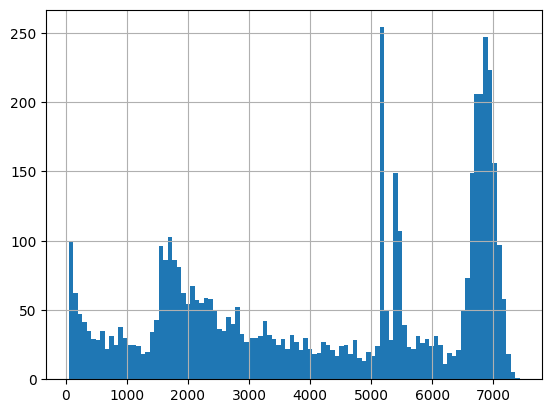

In [93]:
df_lens['tokens'].hist(bins=100)

In [94]:
df_lens['tokens'].describe()

count    5000.000000
mean     4201.559800
std      2322.150605
min        46.000000
25%      2006.750000
50%      4730.500000
75%      6679.000000
max      7431.000000
Name: tokens, dtype: float64

# Balanced dataset

In [10]:
import pandas as pd
balanced_ids = pd.read_parquet('/home/jovyan/maorlov/ggcht/data/mbd/balanced/mbd_targets_balanced.parquet', columns=['client_id'])

In [11]:
balanced_ids.shape

(70532, 1)

In [12]:
ids = set(balanced_ids['client_id'])

In [13]:
json_files = glob('./data/mbd/mm/json/mbd_fold_*.jsonl', recursive=True)
json_files  

['./data/mbd/mm/json/mbd_fold_4.jsonl',
 './data/mbd/mm/json/mbd_fold_0.jsonl',
 './data/mbd/mm/json/mbd_fold_1.jsonl',
 './data/mbd/mm/json/mbd_fold_2.jsonl',
 './data/mbd/mm/json/mbd_fold_3.jsonl']

In [14]:
import json
from tqdm import tqdm

json_data = []

for json_file in json_files:
    with open(json_file) as f:
        for line in tqdm(f):
            x = json.loads(line)
            if x['client_id'] in ids:
                json_data.append(x)
        
print(len(json_data))

196845it [00:08, 22827.66it/s]
196938it [00:08, 23881.85it/s]
196863it [00:08, 22722.70it/s]
196942it [00:08, 22866.68it/s]
196902it [00:08, 22722.53it/s]

69474


In [15]:
with open(f'/home/jovyan/maorlov/ggcht/data/mbd/mm/json_balanced_mm.jsonl', 'w') as outfile:
    for entry in tqdm(json_data):
        json.dump(entry, outfile)
        outfile.write('\n')

100%|██████████| 69474/69474 [00:02<00:00, 26076.29it/s]
